# <center>Predicting Cancer metastates </center>

##  <center> Project for Applied Machine Learning Class </center>
### <center>  -by Srinidhi Kunigal Venkatesha Murthy (SK4356) </center>

# README

## Built-in Functions
* **read_slide**(slide, x, y, level, width, height, as_float=False) - Reads slides
* **positive_samples_from_image**(image_slide, mask_slide, number=100, level=5, patch_size=(100, 100)) - outputs 'number' of samples with tumor for a given patch size
* **negative_samples_from_image**(image_slide, mask_slide, number=100, level=5, patch_size=(100, 100)) - outputs 'number' of samples without tumor for a given patch size
* **test_image**(image_slide, model= model_vgg, level=7, patch_size=(100, 100))- output predicted mask for given image

## Attached Data
* xpos, xng, ypos, yneg - .npy files containing positive and negative patches extracted from 5 slides at (5, 6, 7) levels. y are the associated labels

## Attached Models
* **vgg_model.h5** (best performing, with 0.96 ROC AUC)
* **inception_model.h5**

## Model Results (test accuracy, precision, recall, roc auc)
* **VGG: 90%, 87%, 87%, 0.956
* **Inception: 84%, 80%, 75%, 0.905 

In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 8 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (818 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 110842 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack .

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.patches as mpatches
import seaborn as sns

## Sample Data

In [0]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  59.3M      0  0:00:08  0:00:08 --:--:-- 59.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  16.1M      0 --:--:-- --:--:-- --:--:-- 16.1M


In [0]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide - (x,y) is top left corner of the desired region
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

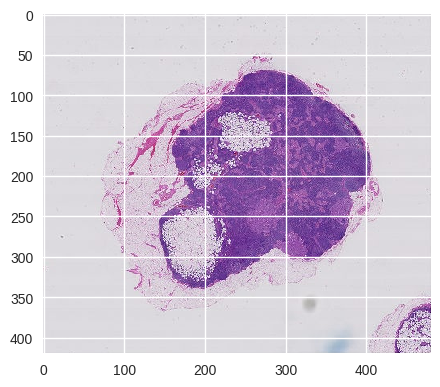

In [0]:
# Example: read the entire slide at level 5

# High zoom levels may not fit into memory.
# That's why we use OpenSlide. You can use the below function
# to extract regions from high zoom levels without having to 
# read the entire image.

# Note: this is just for demo purposes. 

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to see if same region on the mask image contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, x=0, y=0, level=7, 
                         width=slide.level_dimensions[7][0], 
                         height=slide.level_dimensions[7][1])

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_image)

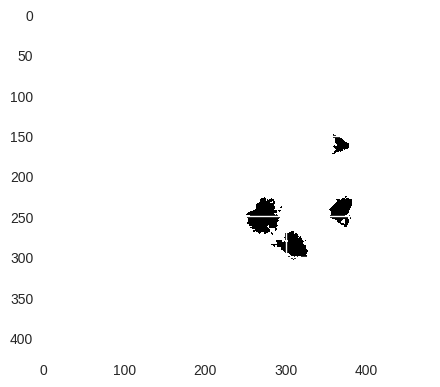

In [0]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, x=0, y=0, level=7, 
                        width=slide.level_dimensions[7][0], 
                        height=slide.level_dimensions[7][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(mask_image)

## Read slides from Google Drive

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
listed = drive.ListFile({'q': "title contains 'tumor'"}).GetList()
# for file in listed:
#   print('title {}, id {}'.format(file['title'], file['id']))

In [0]:
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass
file_list = drive.ListFile(
    {'q': "title contains 'tumor'"}).GetList()
print (file_list)

for f in file_list:
  if f['title'] in ['tumor_005.tif', 'tumor_005_mask.tif',
                    'tumor_012.tif', 'tumor_012_mask.tif',
                    'tumor_016.tif', 'tumor_016_mask.tif',
                    'tumor_031.tif', 'tumor_031_mask.tif',
                    'tumor_091.tif', 'tumor_091_mask.tif',
                    'tumor_110.tif', 'tumor_110_mask.tif']:
  # 3. Create & download by id.
    print('title: %s, id: %s' % (f['title'], f['id']))
    fname = os.path.join(local_download_path, f['title'])
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

[GoogleDriveFile({'kind': 'drive#file', 'id': '10mpGPwuj1o8pYTjNyqWHebsdnXBWllRP', 'etag': '"8xUCra6FbWx8e1S7QPWn-stRIsE/MTUzOTMwMDY2MTI2OQ"', 'selfLink': 'https://www.googleapis.com/drive/v2/files/10mpGPwuj1o8pYTjNyqWHebsdnXBWllRP', 'webContentLink': 'https://drive.google.com/a/columbia.edu/uc?id=10mpGPwuj1o8pYTjNyqWHebsdnXBWllRP&export=download', 'alternateLink': 'https://drive.google.com/a/columbia.edu/file/d/10mpGPwuj1o8pYTjNyqWHebsdnXBWllRP/view?usp=drivesdk', 'embedLink': 'https://drive.google.com/a/columbia.edu/file/d/10mpGPwuj1o8pYTjNyqWHebsdnXBWllRP/preview?usp=drivesdk', 'iconLink': 'https://drive-thirdparty.googleusercontent.com/16/type/text/xml', 'title': 'tumor_078.xml', 'mimeType': 'text/xml', 'labels': {'starred': False, 'hidden': False, 'trashed': False, 'restricted': False, 'viewed': False}, 'copyRequiresWriterPermission': False, 'createdDate': '2018-10-11T23:31:01.269Z', 'modifiedDate': '2018-10-11T23:31:01.269Z', 'markedViewedByMeDate': '1970-01-01T00:00:00.000Z', 'v

In [0]:
train_slides = ['tumor_005.tif','tumor_012.tif', 'tumor_016.tif', 'tumor_031.tif', 'tumor_110.tif']
train_masks = ['tumor_005_mask.tif','tumor_012_mask.tif', 'tumor_016_mask.tif', 'tumor_031_mask.tif', 'tumor_110_mask.tif']

test_slide = open_slide('/root/data/tumor_091.tif')
test_mask = open_slide('/root/data/tumor_091_mask.tif')

In [0]:
train_data = []

for image in train_slides:
  
  path = '/root/data/' + image
  slide= open_slide(path)
  
#   for level in range(5, 8, 1):
#     img= read_slide(slide, x=0, y=0, level=level, 
#                            width=slide.level_dimensions[level][0], 
#                            height=slide.level_dimensions[level][1])
  train_data.append(slide)

In [0]:
mask_data = []

for image in train_masks:
  
  path = '/root/data/' + image
  slide= open_slide(path)
  
#   for level in range(5, 8, 1):
#     img= read_slide(slide, x=0, y=0, level=level, 
#                            width=slide.level_dimensions[level][0], 
#                            height=slide.level_dimensions[level][1])
  mask_data.append(slide)

## Methodology:

1. Extract data: 
    
    a. Extract few images and corresponding masks
    
    b. Extract sub images from levels 5, 6, 7 -> say, 100*100
    
    c. Select center patches of 50*50 in the images
    
    d. Generate labels by looking at mask output
    
2. Train model

3. Test on one image

# Data Processing

In [0]:
def positive_samples_from_image(image_slide, mask_slide, number=100, level=5, patch_size=(100, 100)):
  '''Get n positive samples(with tumor) from a given image slide at magnification level.
  Run a for loop with all images to get the entire positive training set
  Returns: x,y (=1 for all)'''
  
  j=0

  x, y = [], []

  #Loop for the some random big number and break when number needed is reached
  for i in range(200000):

    if j>=number:
      break

    #Generate a random starting point for the patch
    random_start = (np.random.randint(0, image_slide.level_dimensions[level][0]-patch_size[0]), 
                    np.random.randint(0, image_slide.level_dimensions[level][1]-patch_size[1]))

    #Check if this region contains a tumor pixel(s)

    mag = np.power(2, level)

    mask_region = read_slide(mask_slide, x=random_start[0] * mag, y=random_start[1] * mag, 
                             level=level, width=patch_size[0], height=patch_size[1])[:,:,0]
    image_region = read_slide(image_slide, x=random_start[0] * mag, y=random_start[1] * mag, 
                             level=level, width=patch_size[0], height=patch_size[1])
    
    center_mask = read_slide(mask_slide, x=(random_start[0] * mag)+25, y=(random_start[1] * mag)+25, 
                             level=level, width=50, height=50)[:,:,0]
        
    
    #Add ignore non tissue area annd non tumor patches
    if (np.max(mask_region)==0)| (np.mean(rgb2gray(image_region))>0.8): #There is a tumor pixel within and image region has some data
#         print("Yes!")
      continue

    else:
      
      x.append(image_region)
      y.append(1)
      j+=1

  return np.array(x), np.array(y)

In [0]:
def negative_samples_from_image(image_slide, mask_slide, number=100, level=5, patch_size=(100, 100)):
    '''Get n negative samples(no tumor) from a given image. Run a for loop with all images to
  get the entire negative training set
  Returns: x,y (=0 for all)'''
    
    j=0
    x, y = [], []
    
    #Loop for the some random big number and break when number needed is reached
    for i in range(100000):
      
      if j>=number:
        break
    
      #Generate a random starting point for the patch
      random_start = (np.random.randint(0, image_slide.level_dimensions[level][0]-patch_size[0]), 
                      np.random.randint(0, image_slide.level_dimensions[level][1]-patch_size[1]))

      #Check if this region contains a tumor pixel(s)

      mag = np.power(2, level)

      mask_region = read_slide(mask_slide, x=random_start[0] * mag, y=random_start[1] * mag, 
                               level=level, width=patch_size[0], height=patch_size[1])[:,:,0]
      image_region = read_slide(image_slide, x=random_start[0] * mag, y=random_start[1] * mag, 
                               level=level, width=patch_size[0], height=patch_size[1])
      
      
      center_mask = read_slide(mask_slide, x=(random_start[0] * mag)+25, y=(random_start[1] * mag)+25, 
                             level=level, width=50, height=50)[:,:,0]

      #Add ignore non tissue area and tumor patches
      if (np.max(mask_region)==1) | (np.mean(rgb2gray(image_region))>0.8):
#         print("Yes!")
        continue

      else:
        
        x.append(image_region)
        y.append(0)
        j+=1
      
    return np.array(x), np.array(y)

## Select random sample patches from levels 5, 6 & 7 of train set

In [0]:
x_pos, y_pos, x_neg, y_neg = [], [], [], []

for j in [6, 7]:
#   print(j)
  for i in range(len(train_data)):
#     print(i)
    x_p, y_p = positive_samples_from_image(image_slide=train_data[i], mask_slide=mask_data[i], number=150, level=j)
    x_n, y_n = negative_samples_from_image(image_slide=train_data[i], mask_slide=mask_data[i], number=250, level=j)

    x_pos.extend(x_p)
    y_pos.extend(y_p)
    x_neg.extend(x_n)
    y_neg.extend(y_n)

In [0]:
x_pos, y_pos = positive_samples_from_image(image_slide=slide, mask_slide=tumor_mask, number=100)
x_neg, y_neg = negative_samples_from_image(image_slide=slide, mask_slide=tumor_mask, number=500)

In [0]:
print(np.array(x_pos).shape, np.array(x_neg).shape)

(1500, 100, 100, 3) (2500, 100, 100, 3)


In [0]:
np.save('xpos.npy', np.array(x_pos))
np.save('ypos.npy', np.array(y_pos))
np.save('xneg.npy', np.array(x_neg))
np.save('yneg.npy', np.array(y_neg))

In [0]:
# x_pos= np.load('xpos.npy')
# y_pos= np.load('ypos.npy')
# x_neg= np.load('xneg.npy')
# y_neg= np.load('yneg.npy')

In [0]:
x_concat = np.concatenate((x_pos, x_neg))
y_concat = keras.utils.to_categorical(np.concatenate((y_pos, y_neg)))

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_concat, y_concat, random_state= 4356, 
                                                    stratify= y_concat, test_size= 0.2)

In [0]:
y_train.shape

(3200, 2)

In [0]:
x_neg.shape

(2500, 100, 100, 3)

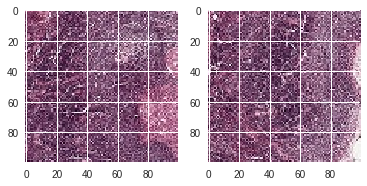

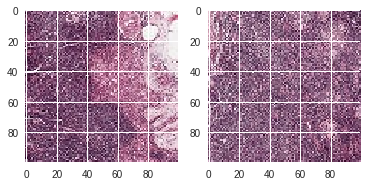

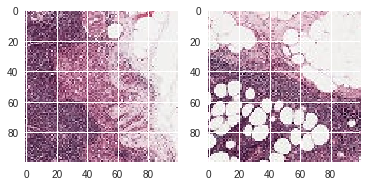

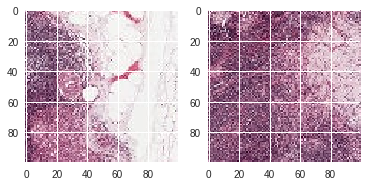

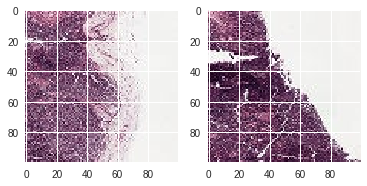

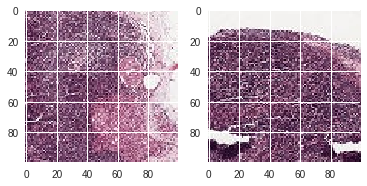

In [0]:
for i in range(6):
  plt.subplots(1,2)
  plt.subplot(1,2,1)
  plt.imshow(x_pos[i])
  plt.subplot(1,2,2)
  plt.imshow(x_neg[i])
  plt.show()

# Model

## Vanilla CNN Model

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 3), padding='same'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 50, 50, 32)        9248      
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 20000)             0         
__________

In [0]:
opt = keras.optimizers.Adam(lr= 1e-1)

In [0]:
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [0]:
history_callback = model.fit(x_train, y_train, batch_size= 64, epochs= 3, verbose=1, validation_split=0.15)

Train on 2720 samples, validate on 480 samples
Epoch 1/3
2720/2720 [==============================] - 13s 5ms/step - loss: 10.0797 - acc: 0.3746 - val_loss: 10.0402 - val_acc: 0.3771
Epoch 2/3
2720/2720 [==============================] - 4s 1ms/step - loss: 10.0797 - acc: 0.3746 - val_loss: 10.0402 - val_acc: 0.3771
Epoch 3/3
2720/2720 [==============================] - 4s 1ms/step - loss: 10.0797 - acc: 0.3746 - val_loss: 10.0402 - val_acc: 0.3771


### Deep convnet model: Not good results however deep I tried

## Transfer Learning

### Inception

In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

In [0]:
model_inception = Sequential()
model_inception.add(InceptionV3(include_top= False, input_shape=(100, 100, 3)))
model_inception.add(Flatten())
model_inception.add(Dense(128, activation='relu'))
# model_inception.add(DropOut(0.3))
# model_inception.add(Dense(128, activation='relu'))
# model_inception.add(DropOut(0.3))
model_inception.add(Dense(2, activation='softmax'))

In [0]:
model_inception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 258       
Total params: 22,065,314
Trainable params: 22,030,882
Non-trainable params: 34,432
_________________________________________________________________


In [0]:
opt = keras.optimizers.Adam(lr=3e-6)
model_inception.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [0]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0)

In [0]:
history_callback = model_inception.fit(x_train, y_train, batch_size= 128, epochs= 40, verbose=1, validation_split=0.15
                                      , callbacks= [callback])

Train on 2720 samples, validate on 480 samples
Epoch 1/40
2720/2720 [==============================] - 46s 17ms/step - loss: 0.2559 - acc: 0.9287 - val_loss: 0.4282 - val_acc: 0.8083
Epoch 2/40
2720/2720 [==============================] - 11s 4ms/step - loss: 0.2489 - acc: 0.9335 - val_loss: 0.4193 - val_acc: 0.8167
Epoch 3/40
2720/2720 [==============================] - 11s 4ms/step - loss: 0.2271 - acc: 0.9441 - val_loss: 0.4112 - val_acc: 0.8187
Epoch 4/40
2720/2720 [==============================] - 11s 4ms/step - loss: 0.2234 - acc: 0.9382 - val_loss: 0.4043 - val_acc: 0.8375
Epoch 5/40
2720/2720 [==============================] - 11s 4ms/step - loss: 0.2086 - acc: 0.9445 - val_loss: 0.4002 - val_acc: 0.8333
Epoch 6/40
2720/2720 [==============================] - 11s 4ms/step - loss: 0.2008 - acc: 0.9533 - val_loss: 0.3961 - val_acc: 0.8396
Epoch 7/40
2720/2720 [==============================] - 11s 4ms/step - loss: 0.1944 - acc: 0.9504 - val_loss: 0.3855 - val_acc: 0.8437
Epoch 8

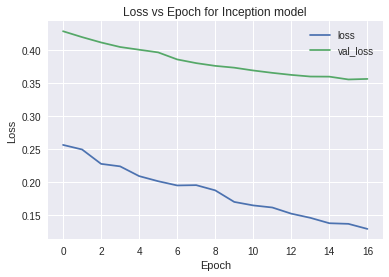

In [0]:
pd.DataFrame(history_callback.history)[['loss', 'val_loss']].plot()
plt.title("Loss vs Epoch for Inception model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [0]:
model_inception.evaluate(x_test, y_test)

800/800 [==============================] - 2s 2ms/step


[0.38652925193309784, 0.8375]

In [0]:
model_inception.save('inception_model.h5')
# model_inception = keras.models.load_model('inception_model.h5')

In [0]:
#Metrics

y_predict = model_inception.predict(x_test)
y_pred = np.argmax(y_predict, axis=1)
precision= precision_score(np.argmax(y_test, axis=1), y_pred)
recall= recall_score(np.argmax(y_test, axis=1), y_pred)
f1= f1_score(np.argmax(y_test, axis=1), y_pred)
auc= roc_auc_score(y_test, y_predict)
print(precision, recall, auc)

0.8035714285714286 0.75 0.9052266666666666


### Inception Results:
* Baseline accuracy: 62.5%
* Test set accuracy: 83.75%
* Precision: 80.3%
* Recall: 75%
* ROC AUC: 0.905

### VGG Model

In [0]:
model_vgg = Sequential()
model_vgg.add(VGG16(include_top= False, input_shape=(100, 100, 3)))
model_vgg.add(Flatten())
model_vgg.add(Dense(128, activation='relu'))
# model_inception.add(DropOut(0.3))
# model_inception.add(Dense(128, activation='relu'))
# model_inception.add(DropOut(0.3))
model_vgg.add(Dense(2, activation='softmax'))

In [0]:
opt = keras.optimizers.Adam(lr=3e-6)
model_vgg.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [0]:
history_callback_vgg = model_vgg.fit(x_train, y_train, batch_size= 128, epochs= 40, verbose=1, validation_split=0.15
                                      , callbacks= [callback])

Train on 2720 samples, validate on 480 samples
Epoch 1/40
2720/2720 [==============================] - 57s 21ms/step - loss: 2.7500 - acc: 0.6437 - val_loss: 2.0161 - val_acc: 0.6958
Epoch 2/40
2720/2720 [==============================] - 16s 6ms/step - loss: 1.1022 - acc: 0.7864 - val_loss: 1.3414 - val_acc: 0.7479
Epoch 3/40
2720/2720 [==============================] - 16s 6ms/step - loss: 0.6124 - acc: 0.8563 - val_loss: 1.0340 - val_acc: 0.8063
Epoch 4/40
2720/2720 [==============================] - 16s 6ms/step - loss: 0.3743 - acc: 0.9074 - val_loss: 0.8925 - val_acc: 0.8396
Epoch 5/40
2720/2720 [==============================] - 16s 6ms/step - loss: 0.2500 - acc: 0.9364 - val_loss: 0.8018 - val_acc: 0.8396
Epoch 6/40
2720/2720 [==============================] - 16s 6ms/step - loss: 0.1752 - acc: 0.9588 - val_loss: 0.7606 - val_acc: 0.8625
Epoch 7/40
2720/2720 [==============================] - 16s 6ms/step - loss: 0.1334 - acc: 0.9717 - val_loss: 0.7163 - val_acc: 0.8687
Epoch 8

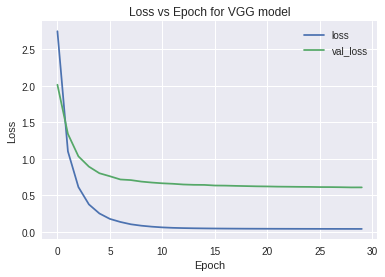

In [0]:
pd.DataFrame(history_callback_vgg.history)[['loss', 'val_loss']].plot()
plt.title("Loss vs Epoch for VGG model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [0]:
model_vgg.save('vgg_model.h5')
# model_vgg = keras.models.load_model('vgg_model.h5')

In [0]:
model_vgg.evaluate(x_test, y_test)

800/800 [==============================] - 2s 3ms/step


[0.4551435224711895, 0.90375]

In [0]:
#Metrics

y_predict_vgg = model_vgg.predict(x_test)
y_pred_vgg = np.argmax(y_predict, axis=1)
precision= precision_score(np.argmax(y_test, axis=1), y_pred_vgg)
recall= recall_score(np.argmax(y_test, axis=1), y_pred_vgg)
f1= f1_score(np.argmax(y_test, axis=1), y_pred_vgg)
auc= roc_auc_score(y_test, y_predict_vgg)
print(precision, recall, auc)

0.8729096989966555 0.87 0.9559566666666666


### VGG Results(significantly better than Inception):
* Baseline accuracy: 62.5%
* Test set accuracy: 90.4%
* Precision: 87.3%
* Recall: 87%
* ROC AUC: 0.956

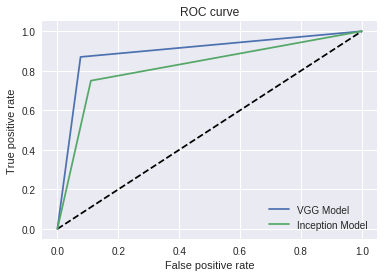

In [0]:
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(np.argmax(y_test, axis=1), y_pred_vgg)
fpr_rf, tpr_rf, _ = roc_curve(np.argmax(y_test, axis=1), y_pred)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='VGG Model')
plt.plot(fpr_rf, tpr_rf, label='Inception Model')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


## Model Results: Testing on Image 91

In [0]:
l=[]
l.append(np.full(shape= (100, 100, 3), fill_value= 0))
np.array(l).shape

(1, 100, 100, 3)

In [0]:
def test_image(image_slide, model= model_vgg, level=7, patch_size=(100, 100)):
  '''Takes slide as input and produces mask'''
        
  h= image_slide.level_dimensions[level][1]
  w= image_slide.level_dimensions[level][0]

  c_h = int(h/100)
  c_w = int(w/100)

  mask = np.full(shape= (h, w), fill_value= 0)

  #Loop for the some random big number and break when number needed is reached
  for i in range(c_h):
    for j in range(c_w):

      x_start=i*100
      y_start=j*100

      #Check if this region contains a tumor pixel(s)
      img=[]
      
      mag = np.power(2, level)

      image_region = read_slide(image_slide, x=x_start * mag, y=y_start * mag, 
                               level=level, width=patch_size[0], height=patch_size[1])
      
      img.append(image_region)
      prediction = model.predict(np.array(img))
      pred= np.argmax(prediction, axis=1)
      
      if (np.mean(rgb2gray(image_region))>0.8): continue

#       img = np.expand_dims(image_region, axis=0)
#       image_region= image_region.reshape((1, 100, 100, 3))
#       print(img.shape)
      
      elif pred==1 :
        continue

      else:
        mask[x_start:x_start+100, y_start:y_start+100] =1

  return mask

In [0]:
mask= test_image(test_slide, m=model_vgg, level=7)

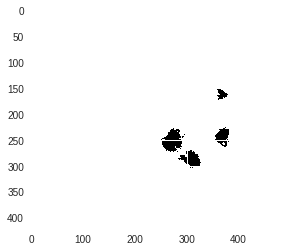

In [0]:
# plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

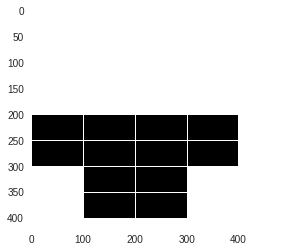

In [0]:
# plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask)

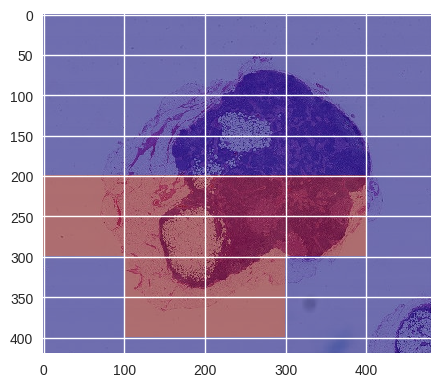

In [0]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask, cmap='jet', alpha=0.5) # Red regions contains cancer.

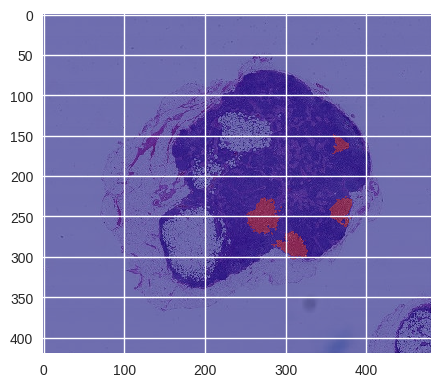

In [0]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

### Result: Few False positives and only one missed region!